In [2]:
# Include so results on different machines are (should be) the same.
from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

In [3]:
!jupyter nbconvert --to script Keras_Character_MultiHeadRNN.ipynb

[NbConvertApp] Converting notebook Keras_Character_MultiHeadRNN.ipynb to script
[NbConvertApp] Writing 15047 bytes to Keras_Character_MultiHeadRNN.py


In [2]:
import glob, os, json, re, unicodedata
from bs4 import BeautifulSoup

load_verbose = 0
loaded_labels = []
loaded_text = []
presidents = [
    "Barack Obama",
    "Donald J. Trump",
    "Dwight D. Eisenhower",
    "Franklin D. Roosevelt",
    "George Bush",
    "George W. Bush",
    "Gerald R. Ford",
    "Harry S. Truman",
    "Herbert Hoover",
    "Jimmy Carter",
    "John F. Kennedy",
    "Lyndon B. Johnson",
    "Richard Nixon",
    "Ronald Reagan",
    "William J. Clinton"
]

labels = {}
for idx, name in enumerate(presidents):
    labels[name] = idx

# load raw text files straight in, no parsing
file_to_label = {
    "Obama": "Barack Obama",
    "Trump": "Donald J. Trump",
    "Eisenhower": "Dwight D. Eisenhower",
    "Roosevelt": "Franklin D. Roosevelt",
    "Bush": "George Bush",
    "WBush": "George W. Bush",
    "Ford": "Gerald R. Ford",
    "Truman": "Harry S. Truman",
    "Hoover": "Herbert Hoover",
    "Carter": "Jimmy Carter",
    "Kennedy": "John F. Kennedy",
    "Johnson": "Lyndon B. Johnson",
    "Nixon": "Richard Nixon",
    "Reagan": "Ronald Reagan",
    "Clinton": "William J. Clinton"
}

directory = "../data/processed/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 


print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."
# processed2 now contains files generated from unprocessed
directory = "../data/processed3/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 

print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."

Loaded 47 speeches for 14 presidents.
Loaded 1764 speeches for 15 presidents.


In [3]:
#
# Bagnall 2015 text pre-processing
#
from string import maketrans
import re

chars_to_replace = "[]%!()>=*&_}+"
sub_chars = len(chars_to_replace) * " "
trantab = maketrans(chars_to_replace, sub_chars)
for x in range(0,len(loaded_text)):
    # "Various rare characters that seemed largely equivalent are mapped together..."
    loaded_text[x] = re.sub('`', '\'', loaded_text[x])
    loaded_text[x] = re.sub('--', '-', loaded_text[x])
    loaded_text[x] = re.sub('\n\n', '\n', loaded_text[x])
    # "...all digits in all languages are mapped to 7"
    loaded_text[x] = re.sub('[0-9]+', '7', loaded_text[x])
    # "...any character with a frequency lower than 1 in 10,000 is discarded."
    loaded_text[x] = loaded_text[x].translate(trantab)
    # "Runs of whitespace are collapsed into a single space."
    loaded_text[x] = re.sub(' +', ' ', loaded_text[x])
     
    # REPLACE WORD IN ALL CAPS with <space>; headers
    loaded_text[x] = re.sub('[A-Z]{2,}','', loaded_text[x])

print "Character clean-up complete."

Replacements complete.


In [4]:
#
# Join all speeches into one massive per president
#  for later processing
#
import numpy as np
from scipy import stats
from operator import itemgetter
from collections import defaultdict

compressed_text = [None]*(len(labels))
for key, value in sorted(labels.iteritems()):
    compressed_text[value] = ""
    for idx in range(0,len(loaded_text)):
        if (loaded_labels[idx] == value):
            compressed_text[value] = compressed_text[value] + loaded_text[idx] + " "
            
print "How many characters of text per president?"
for key, value in sorted(labels.iteritems()):
    print str(value).ljust(2), ":", key.ljust(20), "\t", len(compressed_text[value])

label_min_chars = len(min(compressed_text, key=len))
print "\nMinimum number of characters per president?"
print label_min_chars

How many characters of text per president?
0  : Barack Obama         	4862045
1  : Donald J. Trump      	554978
2  : Dwight D. Eisenhower 	3084215
3  : Franklin D. Roosevelt 	1743457
4  : George Bush          	1896536
5  : George W. Bush       	1791014
6  : Gerald R. Ford       	687272
7  : Harry S. Truman      	2001118
8  : Herbert Hoover       	786184
9  : Jimmy Carter         	1272152
10 : John F. Kennedy      	1344012
11 : Lyndon B. Johnson    	2288606
12 : Richard Nixon        	972275
13 : Ronald Reagan        	1010291
14 : William J. Clinton   	1784166

Minimum number of characters per president?
554978


In [5]:
#
# Tokenize words into chars
#
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Tokenize into characters
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(compressed_text)
tokenized_text = tokenizer.texts_to_sequences(compressed_text)

# there's an oddity in the encoding for some reason where a len+1 character occurs
unique_chars = len(tokenizer.word_counts)+1

print "Unique char count:", unique_chars
print "\nChars w/ counts:"
print sorted(((v,k) for k,v in tokenizer.word_counts.iteritems()), reverse=True)

Couldn't import dot_parser, loading of dot files will not be possible.


Using TensorFlow backend.


Unique char count: 68

Chars w/ counts:
[(4725447, ' '), (2569974, 'e'), (2131220, 't'), (1627649, 'o'), (1609954, 'a'), (1476541, 'n'), (1405067, 'i'), (1193120, 's'), (1157275, 'r'), (1066798, 'h'), (755187, 'l'), (705084, 'd'), (548669, 'u'), (534278, 'c'), (478832, 'm'), (418343, 'w'), (393337, 'g'), (389784, 'f'), (382020, 'p'), (374441, 'y'), (281512, 'b'), (264600, ','), (263713, '.'), (240856, 'v'), (162701, 'I'), (151063, 'k'), (95930, "'"), (62618, 'A'), (49111, 'S'), (47587, 'T'), (44390, '-'), (40548, '7'), (39451, 'W'), (32811, 'x'), (29785, 'C'), (25503, 'j'), (23659, 'B'), (23374, 'M'), (22167, 'N'), (21726, 'q'), (21723, 'P'), (16943, 'G'), (14374, 'H'), (13620, 'U'), (12142, 'D'), (11930, 'z'), (11837, 'R'), (10677, 'F'), (10672, '"'), (10127, 'E'), (9435, 'O'), (9370, 'Y'), (9360, ';'), (8141, '?'), (7920, 'J'), (7822, 'L'), (6390, ':'), (4737, '\n'), (3981, '$'), (3943, 'K'), (3705, 'V'), (1853, '/'), (1066, 'Q'), (338, 'Z'), (80, 'X'), (6, '#'), (4, '\\')]


In [6]:
#
# Split speeches into subsequences 
#
from collections import Counter

def splits(_list, _split_size, window=False):
    output_list = []
    if (window):
        for idx in range(0, len(_list)-_split_size):
            output_list.append(_list[idx:idx + _split_size])
    else:
        for idx in range(0, len(_list), _split_size):
            if (idx + _split_size) <= len(_list):
                output_list.append(_list[idx:idx + _split_size])
    return output_list

max_seq_len = 25

# create new speech/label holders
split_text = []
split_labels = []

for idx in range(0, len(tokenized_text)):
    current_label = idx
    current_speech = tokenized_text[idx]#[:label_min_chars]
    current_splits = splits(current_speech, max_seq_len)
    split_text.extend(current_splits)
    split_labels.extend([current_label] * len(current_splits))

print "Subsequence total count; subsequence label total count:", len( split_text ), len( split_labels )
print "\nTotal characters:", len( split_text ) * max_seq_len

Subsequence total count; subsequence label total count: 1043126 1043126

Total characters: 26078150


In [7]:
#
# split amongst speaker samples, not the whole population of samples
#
def split_test_train(input_text, input_labels, labels, train_pct=0.8):
    train_text = []
    train_labels = []
    test_text = []
    test_labels = []

    for key, value in sorted(labels.iteritems()):
        # grab all values of a specific label
        subset_text = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_text))
        subset_labels = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_labels))
        
        cut_pos = int(train_pct * len(subset_text))
        train_text = train_text + subset_text[:cut_pos]
        train_labels = train_labels + subset_labels[:cut_pos]
        test_text = test_text + subset_text[cut_pos:]
        test_labels = test_labels + subset_labels[cut_pos:]
        
    return train_text,train_labels,test_text,test_labels

In [8]:
#
# Prep test/train
#
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight

# split data smartly
train_X, train_y, test_X, test_y = split_test_train(split_text, split_labels, 
                                                    labels, train_pct=0.8)
print "Splits:\n Test = ", len(train_X), "\n Train = ", len(test_X)##

# compute class weights to account for imbalanced classes
y_weights = (class_weight.compute_class_weight('balanced', np.unique(train_y), train_y)).tolist()
y_weights = dict(zip(sorted(labels.values()), y_weights))
print "Class weights:\n", y_weights

Splits:
 Test =  834494 
 Train =  208632
Class weights:
{0: 0.35757490058960645, 1: 3.1326613735758393, 2: 0.5636911396167278, 3: 0.9971846806476669, 4: 0.916704016170138, 5: 0.9707030522985297, 6: 2.5296895840911846, 7: 0.8687894640951563, 8: 2.2114295557233903, 9: 1.3666339130719596, 10: 1.2935484871031746, 11: 0.7596495300516601, 12: 1.7881503385617554, 13: 1.7208900437185515, 14: 0.9744435881267661}


In [9]:
#
# One-hot encoding classes & samples
#
from keras.utils import to_categorical

# one-hot encode classes
train_y = np.array(to_categorical(train_y))
test_y = np.array(to_categorical(test_y))

# one-hot encode samples
train_X = np.array(train_X)
orig_train_X_size=train_X.shape[0]
print "Encoding train_X with dimensions ", train_X.shape
train_X = to_categorical(train_X, num_classes=unique_chars)
print "...to ", train_X.shape
train_X = np.reshape(train_X,(orig_train_X_size,max_seq_len,unique_chars))
print "...and reshaping to ", train_X.shape

test_X = np.array(test_X)
orig_test_X_size=test_X.shape[0]
print "\nEncoding test_X with dimensions ", test_X.shape
test_X = to_categorical(test_X, num_classes=unique_chars)
print "...to ", test_X.shape
test_X = np.reshape(test_X,(orig_test_X_size,max_seq_len,unique_chars))
print "...and reshaping to ", test_X.shape

Encoding train_X with dimensions  (834494, 25)
...to  (20862350, 68)
...and reshaping to  (834494, 25, 68)

Encoding test_X with dimensions  (208632, 25)
...to  (5215800, 68)
...and reshaping to  (208632, 25, 68)


In [10]:
# custom activation from Bagnall 2015
#  does not appear to perform as well as a ReLU
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects

def ReSQRT(x):
    cond = tf.less_equal(x, 0.0)
    result = tf.where(cond, x * 0.0, tf.sqrt(x+1)-1)
    return result

get_custom_objects().update({'ReSQRT': ReSQRT})

Bagnall proposes that the following possible values contribute to the success of the model:

| meta-parameter                  	| typical value                      	|
|---------------------------------	|------------------------------------	|
| initial adagrad learning scale  	| 0.1, 0.14, 0.2, 0.3                	|
| initial leakage between classes 	| 1/4N to 5/N                        	|
| leakage decay (per sub-epoch)   	| 0.67 to 0.9                        	|
| hidden neurons                  	| 79, 99, 119, 139                   	|
| presynaptic noise σ             	| 0, 0.1, 0.2, 0.3, 0.5              	|
| sub-epochs                      	| 6 to 36                            	|
| text direction                  	| forward or backward                	|
| text handling                   	| sequential, concatenated, balanced 	|
| initialisation                  	| gaussian, zero                     	|

In [ ]:
##
## BASELINE
##
from keras.layers import Input, Dense, SimpleRNN, Bidirectional, Dropout, TimeDistributed
from keras.layers.merge import Maximum, Add, Concatenate
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from keras.layers.merge import Average, Maximum
from keras.optimizers import Adagrad, adam
from keras.models import Model
from keras.utils import plot_model

# define operating vars
activation = "relu" #"ReSQRT" 
units = 150# 50
dropout = 0.7646166765488501
batch_size = 50# 100
epochs = 100
optimizer='adamax'#'rmsprop'
shuffle=True #False

# define any callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
              patience=2, verbose=1)
csv_logger = CSVLogger('Keras_Character_MultiHeadRNN.log')

# assemble & compile model
input = Input(shape=(max_seq_len,unique_chars,))
rnn = Bidirectional(SimpleRNN(units=units,activation=activation))(input)

## not entirely sure this makes sense, but it does seem to work...
soft_out = []
for idx in range(0,len(labels)):
    soft_out.append(Dense(len(labels),activation='softmax', kernel_initializer='random_normal')(rnn))
final_out = Add()(soft_out)

model = Model(inputs=[input], outputs = final_out) 

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['categorical_accuracy'])
plot_model(model, to_file='Keras_Character_MultiHeadRNN.png', show_shapes=True, show_layer_names=True)
print(model.summary())

In [ ]:
# train the model
model.fit([np.array(train_X)],
          [np.array(train_y)],
          batch_size=batch_size,
          epochs=epochs,
          shuffle=shuffle,
          class_weight = y_weights,
          callbacks=[reduce_lr, csv_logger],
          verbose=1)

model.save('Keras_Character_MultiHeadRNN.h5')
print ("Model saved.")
del model

In [11]:
### Load computed model
from keras.models import load_model
# returns a compiled model identical to the one trained
model = load_model('Keras_Character_MultiHeadRNN.h5')
print "Model loaded." 

Model loaded.


In [12]:
from sklearn import metrics

batch_size = 50# 100

# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(test_X, test_y)
print model.metrics_names
print loss_and_metrics

# Make some predictions
print "\nPredicting using test data..."
pred_y = model.predict(test_X, batch_size=batch_size, verbose=1)
pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(test_y, axis=1)
print "\n\nDone prediction."

print "\nAUC = ", metrics.roc_auc_score(test_y, pred_y)

Evaluating test data...
208416/208632 [============================>.] - ETA: 0s['loss', 'categorical_accuracy']
[2.4360797346458787, 0.18888281759298481]

Predicting using test data...
208350/208632 [============================>.] - ETA: 0s

Done prediction.

AUC =  0.709903758046


Confusion matrix, without normalization
[[7363 4844 1443 1893 2475 5077 1620  989 2063 2812 1204  866 1432 2671
  2145]
 [ 398 1062  212  466  373  624   89  307  159  105   54   91  100  243
   157]
 [ 812 1240 3832 2740  920  476 1491 2055 2706 1180 2097  966 1975 1366
   818]
 [ 373 1224 1114 3436  432  460  495 1289 1850  470  726  424  606  686
   363]
 [1406 1298  801  873 1943 1578  920  937  790 1063  556  443  691 1016
   858]
 [2064 1599  540  773 1089 2885  555  495  693  965  378  302  401  822
   767]
 [ 200  201  263  243  192  135 1032  386  592  591  313  422  531  213
   184]
 [ 258  781  998 1568  421  282  816 5573 1728  369  649 1187  697  368
   314]
 [ 101  208  219  533   38   33  342  487 2840  321  383  323  264  124
    74]
 [ 705  504  380  419  451  472 1210  376 1172 2004  650  398  621  455
   361]
 [ 392  330  535  582  265  207  974  678 1547  888 1967  610 1021  446
   310]
 [ 533  889 1010 1340  380  317 1979 2480 2503  935 1100 2161 1461  687
   534]


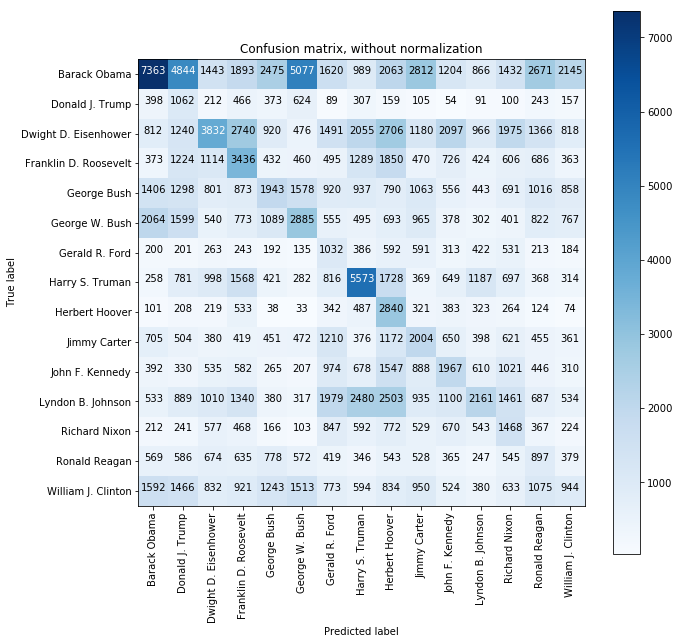

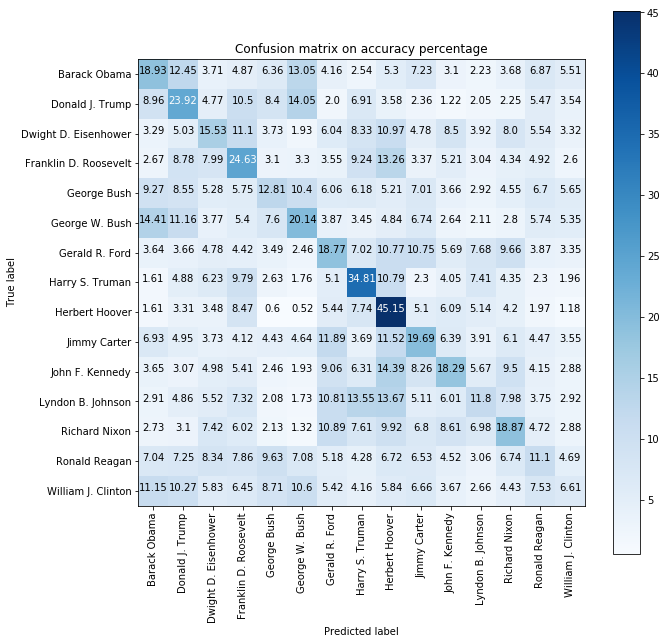

In [13]:
# Plot confusion matrix
#   from scikit-learn examples @
#   http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix, without normalization')

plt.show()

In [ ]:
#Plot normalized confusion matrix
cnf_matrix_pct = cnf_matrix *1.0
cnf_matrix_pct = np.around(np.array([row*100.0/sum(row) for row in cnf_matrix_pct]), 2)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix_pct, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix on accuracy percentage')
plt.show()

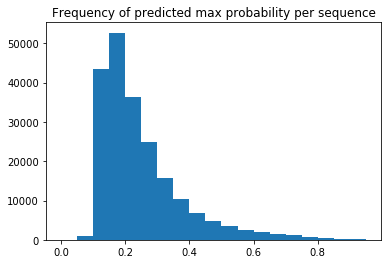

In [14]:
binwidth = .05
pred_outs = pred_y/len(labels)
plt.hist(pred_outs.max(axis=1),bins=np.arange(0.0, 1.0, 0.05))
plt.title('Frequency of predicted max probability per sequence')
plt.show()

In [15]:
sample_idx = 20000
print "Predicted President: ", np.argmax(labels[pred_y[sample_idx]])
print "Actual President: ", np.argmax(labels[test_y[sample_idx]])
print split_text[sample_idx-1:sample_idx+1]

# print one sequence on either side of confused
sample = split_text[sample_idx-1:sample_idx+1]
sample = sum(sample, [])
sample_txt = ""
tokenizer_rev = {v: k for k, v in tokenizer.word_index.items()}
for char in sample:
    sample_txt += tokenizer_rev[char]
print sample_txt

14
0
[[6, 17, 1, 24, 2, 9, 20, 1, 8, 2, 6, 8, 7, 21, 11, 2, 1, 19, 9, 2, 14, 5, 13, 3, 7], [4, 6, 8, 1, 3, 10, 5, 3, 1, 14, 5, 6, 1, 15, 5, 26, 2, 1, 5, 1, 10, 13, 17, 2, 1]]
ng very sensible precautions that can make a huge 
